# Marketing A/B Testing

Simple marketing campaign with experiment and control group for A/B testing [(Kaggle dataset)](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data).

The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

**Data dictionary:**

- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Read data and clean up column names
df = pd.read_csv('marketing_campaign.csv', index_col=0)
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [4]:
# Descriptive statistics
df.describe(include="all").round(1)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
count,588101.0,588101,588101,588101.0,588101,588101.0
unique,NaN,2,2,NaN,7,NaN
top,NaN,ad,False,NaN,Friday,NaN
freq,NaN,564577,573258,NaN,92608,NaN
mean,1310692.2,NaN,NaN,24.8,NaN,14.5
std,202226.0,NaN,NaN,43.7,NaN,4.8
min,900000.0,NaN,NaN,1.0,NaN,0.0
25%,1143190.0,NaN,NaN,4.0,NaN,11.0
50%,1313725.0,NaN,NaN,13.0,NaN,14.0
75%,1484088.0,NaN,NaN,27.0,NaN,18.0


In [5]:
# Check for duplicates
df[df["user_id"].duplicated()]

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour


## A/B Testing

If the campaign was successful, how much of that success could be attributed to the ads?

**1. Choose outcomes**
   
   - Evaluation metric: conversion rate

   - Invariate metrics: total ads, hour of the day with most ads

   - Null Hypothesis: the conversion rate of the control group is the same as the conversion rate of the experimental group

   - Alternative Hypothesis: the conversion rate of the control group is different from the conversion rate of the experimental group

In [6]:
df.groupby('test_group').agg({'user_id': 'count', 
                              'converted': ['sum', 'mean'], 
                              'total_ads': 'mean', 
                               'most_ads_hour': 'mean'}).round(3)

user_id converted        total_ads most_ads_hour
             count       sum   mean      mean          mean
test_group                                                 
ad          564577     14423  0.026    24.823        14.476
psa          23524       420  0.018    24.761        14.305

2. Choose baseline values and statistical levels: 
   
   - Baseline conversion rate: 0.02 (2%)
   - Baseline total ads: 25
   - Baseline hour of the day with most ads: 2PM
   - Statistical significance level: 0.05
   - Statistical power: 0.8
   - Minimum detectable effect: 0.01 (1%)

In [15]:
# Baseline and statistical levels
baseline_rate = 0.02
baseline_total_ad = 25
baseline_most_ad_hour = 14
alpha = 0.05
beta = 0.2
power = 1 - beta
mde = 0.01

**3. Experiment size:**
   
$$
n_1=\frac{(r+1)}{r} \frac{\sigma^2\left(Z_{\text{power}} + \mathrm{Z}_{\alpha / 2}\right)^2}{\text{difference}^2}
$$

In [16]:
# Total users in each group
total_ad = df.loc[df.test_group == 'ad', 'converted'].count()
total_no_ad = df.loc[df.test_group == 'psa', 'converted'].count()
# Total converted users in each group
converted_ad = df.loc[df.test_group == 'ad', 'converted'].sum()
converted_no_ad = df.loc[df.test_group == 'psa', 'converted'].sum()
# Conversion rate in each group
mean_ad = df.loc[df.test_group == 'ad', 'converted'].mean()
mean_no_ad = df.loc[df.test_group == 'psa', 'converted'].mean()
# Difference in conversion rate
diff = mean_ad - mean_no_ad

In [17]:
# Standard normal distribution
standard_norm = stats.norm(0, 1)
# Find Z_beta from desired power
Z_beta = standard_norm.ppf(power)
# Find Z_alpha
Z_alpha = standard_norm.ppf(1-alpha/2)
# Average of probabilities from both groups
pooled_prob = (baseline_rate + baseline_rate + mde) / 2
# Minimum sample size required on each group
min_N = 2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / mde**2
print(f"Minimum sample size required on each group: {np.ceil(min_N):.0f}")

Minimum sample size required on each group: 3827


In [11]:
# Minimum sample size required when ratios are different
ratio = total_ad / total_no_ad
min_N = pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / mde**2 * (ratio+1)/ratio
print(f"Minimum sample size required with {ratio:.0f}:1 ratio: group1 = {np.ceil(min_N):.0f}, group2 = {np.ceil(min_N*ratio):.0f}")

Minimum sample size required with 24:1 ratio: group1 = 3778, group2 = 90672


**4. Run test**

Null Hypothesis: Conversion rate is the same for both groups (Ads did not have an effect)

Alt Hypothesis: Conversion rate differs between groups (Ads had an effect)

$$
\text{CI} = \left[\hat{d} - Z_{1-\frac{\alpha}{2}} \text{SE}_{\text{pool}}, \ \ \hat{d} + Z_{1-\frac{\alpha}{2}} \text{SE}_{\text{pool}}\right]
$$

where $\text{SE}_{\text{pool}} = \sqrt{\operatorname{Var}(\hat{d})}=\sqrt{\frac{s_A^2}{n_A}+\frac{s_B^2}{n_B}} \ $, $\hat{d} = \bar{p}_B - \bar{p}_A \ $, and $s^2 = p(1-p)$ (analytical formula from binomial distribution)

In [12]:
print(f"Mean conversion rate for AD group: {mean_ad:.4f} or {mean_ad*100:.1f}%")
print(f"Mean conversion rate for PSA group: {mean_no_ad:.4f} or {mean_no_ad*100:.1f}%")
print(f"Difference in conversion rates: {diff:.4f} or {diff*100:.1f}%")

Mean conversion rate for AD group: 0.0255 or 2.6%
Mean conversion rate for PSA group: 0.0179 or 1.8%
Difference in conversion rates: 0.0077 or 0.8%


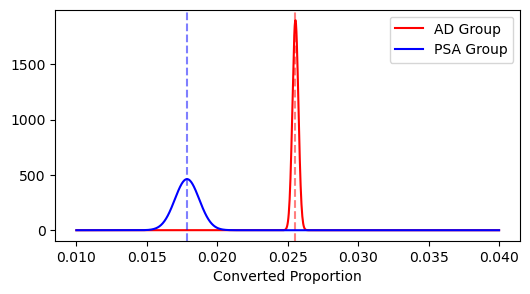

In [13]:
# Standard error in each group
se_ad = np.sqrt(mean_ad * (1-mean_ad)) / np.sqrt(total_ad) # analytical formula
# se_ad = df.loc[df.test_group == 'psa', 'converted'].std() / np.sqrt(total_ad) # empirical formula
se_no_ad = np.sqrt(mean_no_ad * (1-mean_no_ad)) / np.sqrt(total_no_ad)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(6,3))
x = np.linspace(0.01, 0.04, 1000)
yA = stats.norm(mean_ad, se_ad).pdf(x)
ax.plot(x, yA, c='red', label='AD Group')
ax.axvline(x=mean_ad, c='red', alpha=0.5, linestyle='--')
yB = stats.norm(mean_no_ad, se_no_ad).pdf(x)
ax.plot(x, yB, c='blue', label='PSA Group')
ax.axvline(x=mean_no_ad, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.legend()
plt.show()

In [14]:
se_pooled = np.sqrt(mean_ad*(1-mean_ad)/total_ad + mean_no_ad*(1-mean_no_ad)/total_no_ad)
ci = (diff - Z_alpha * se_pooled, diff + Z_alpha * se_pooled)
print(f"Confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Confidence interval: 0.0054 to 0.0100


In [15]:
# This is the same as regression
t_results = stats.ttest_ind(df.loc[df.test_group == 'ad', 'converted'], 
                            df.loc[df.test_group == 'psa', 'converted'])
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 7.3704 with p-value: 0.0000


In [16]:
# Welch's t-test
t_results = stats.ttest_ind(df.loc[df.test_group == 'ad', 'converted'], 
                            df.loc[df.test_group == 'psa', 'converted'], equal_var=False)
print(f"Welch's t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

Welch's t-statistic: 8.6572 with p-value: 0.0000


**5. Conclusions:**

- If the confidence interval does not contain zero, we can reject the null hypothesis and conclude that the ads had an effect on the conversion rate.

- If we run the experiment many times, we would expect the confidence interval to contain the true effect 95% of the time.

- This is not the same as saying that we are 95% confident that the true effect is contained in the confidence interval (you would need a Bayesian approach).

- Practical significance: if the ads had an effect, how big was it? Is it worth the cost of the campaign an effect of 0.5 to 1% conversion rate?

**Sanity Checks (TO DO)**

Check if the invariate metrics are similar between groups.

In [ ]:
# Invariant metric: total_ads
t_results = stats.ttest_ind(df.loc[df.test_group == 'ad', 'total_ads'], 
                            df.loc[df.test_group == 'psa', 'total_ads'])
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 0.2139 with p-value: 0.8306


In [ ]:
# Invariant metric: most_ads_hour
t_results = stats.ttest_ind(df.loc[df.test_group == 'ad', 'most_ads_hour'], 
                            df.loc[df.test_group == 'psa', 'most_ads_hour'])
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 5.3147 with p-value: 0.0000


## Bootstrap

If the sample size is small, we can use bootstrapping to estimate the confidence interval.

In [47]:
# Bootstrap A/B testing
n = 100
boot_diff = []

for _ in range(n):
    sample = df.sample(frac=1, replace=True)
    ad = sample.loc[sample.test_group == 'ad', 'converted'].mean()
    psa = sample.loc[sample.test_group == 'psa', 'converted'].mean()
    boot_diff.append(ad - psa)

ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Bootstrap confidence interval: 0.0061 to 0.0095


**Sanity Checks (TO DO)**

Check if the invariate metrics are similar between groups using bootstrap.

In [48]:
# Bootstrap A/B testing
n = 100
boot_diff = []

for _ in range(n):
    sample = df.sample(frac=1, replace=True)
    ad = sample.loc[sample.test_group == 'ad', 'total_ads'].mean()
    psa = sample.loc[sample.test_group == 'psa', 'total_ads'].mean()
    boot_diff.append(ad - psa)

ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Bootstrap confidence interval: -0.4918 to 0.5403


In [49]:
# Bootstrap A/B testing
n = 100
boot_diff = []

for _ in range(n):
    sample = df.sample(frac=1, replace=True)
    ad = sample.loc[sample.test_group == 'ad', 'most_ads_hour'].mean()
    psa = sample.loc[sample.test_group == 'psa', 'most_ads_hour'].mean()
    boot_diff.append(ad - psa)

ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Bootstrap confidence interval: 0.1107 to 0.2357


## [Quantile A/B Testing](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/)

[Streaming Video Experimentation at Netflix: Visualizing Practical and Statistical Significance](https://netflixtechblog.com/streaming-video-experimentation-at-netflix-visualizing-practical-and-statistical-significance-7117420f4e9a)

If we care more about the tails of the distribution, we can use quantile A/B testing.

In [40]:
import numpy as np
from numpy.random import normal, binomial

alpha=.05
quantile_of_interest=0.5
sample_size=10000
number_of_bootstrap_samples=1000000
outcome_control_sorted = np.sort(normal(1,1,sample_size))
outcome_treatment_sorted = np.sort(normal(1.2,1,sample_size))

bootstrap_difference_distribution = outcome_treatment_sorted[binomial(sample_size+1, quantile_of_interest,
number_of_bootstrap_samples)] - outcome_control_sorted[binomial(sample_size+1,
                        quantile_of_interest, number_of_bootstrap_samples)]
bootstrap_confidence_interval = np.quantile(bootstrap_difference_distribution,
[alpha/2 , 1-alpha/2])

print(f"The sample difference-in-medians is \
{np.quantile(outcome_treatment_sorted, quantile_of_interest)-np.quantile(outcome_control_sorted, quantile_of_interest)},\
the {(1-alpha)*100}% confidence interval for the difference-in-medians is given by ({bootstrap_confidence_interval}).")

The sample difference-in-medians is 0.20011866072941542,the 95.0% confidence interval for the difference-in-medians is given by ([0.16889293 0.23922737]).


In [46]:
import numpy as np
from scipy.stats import binom

alpha=.05
quantile_of_interest=0.5
sample_size=10000
number_of_bootstrap_samples=1000000
replications = 10000

bootstrap_confidence_intervals = []
ci_index = int(np.floor(binom.ppf(alpha,sample_size+1,
quantile_of_interest)))
for i in range(replications):
    outcome_sorted = np.sort(np.random.normal(0,1,sample_size))
    bootstrap_confidence_intervals.append(outcome_sorted[ci_index])

f"The empirical false positive rate of the test using the bootstrap confidence interval is {np.mean([1 if i>0  else 0 for i in bootstrap_confidence_intervals])*100}%, the intended false positive rate is {alpha*100}%"

'The empirical false positive rate of the test using the bootstrap confidence interval is 5.140000000000001%, the intended false positive rate is 5.0%'

[Udacity A/B Testing](https://www.kaggle.com/code/tammyrotem/ab-tests-with-python)

[The Math Behind A/B Testing](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)